## Denoising Images using Autoencoders
This notebook will be demonstrating denoising process of an image dataset ( cifar10 in this case) using an Autoencoder model.

## Setting up prerequisites

In [1]:
#  Importing all libraries required
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import math
import multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from random import randint
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
#  configuring device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


## Data preprocessing

In [3]:
#  Adding gaussian noise

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
    AddGaussianNoise(0., 0.2)
])


## Setting up Dataloaders and creating train / test split

In [4]:
#  Calling datsets and and defining Dataloaders for the training and testing models
n_cpus = mp.cpu_count()


train_ds = Datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_ds = Datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
train_ds_noisy = Datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_noisy)
test_ds_noisy = Datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_noisy)


train_dl = DataLoader(train_ds, batch_size=32,shuffle=True, num_workers=n_cpus,pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32,shuffle=False, num_workers=n_cpus,pin_memory=True)
train_dl_noisy = DataLoader(train_ds_noisy, batch_size=32,shuffle=True, num_workers=n_cpus,pin_memory=True)
test_dl_noisy = DataLoader(test_ds_noisy, batch_size=32,shuffle=False, num_workers=n_cpus,pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Data visualization

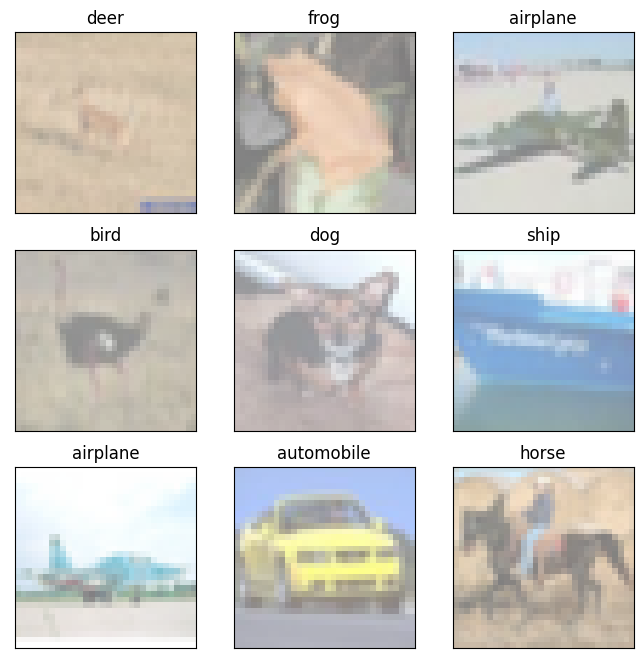

In [5]:
#  Print some random images from the training data set.

#U tility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
# Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


In [6]:
class_names = train_ds.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
len(train_ds),len(test_ds),

(50000, 10000)

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, tolerance=0):
       # How many epochs in a row the model is allowed to underperform
        self.patience = patience
       # How much leeway the model has (i.e. how close it can get to underperforming before it is counted as such)
        self.tolerance = tolerance
       # Keeping track of how many epochs in a row were failed
        self.epoch_counter = 0
       # Keeping track of best metric so far
        self.max_validation_acc = np.NINF

    def should_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.epoch_counter = 0
        elif validation_acc < (self.max_validation_acc - self.tolerance):
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True

        return False

In [9]:
# Saves a model to file, and names it after the current epoch
def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pt"
    save_path = os.path.join(save_dir, filename)
    torch.save(model, save_path)

## Defining Train and Validation functions

In [10]:
# Defining train function 
def train(model, train_dl, optimizer, criterion, device, idx,lr_scheduler, stopper,writer,checkpoint_frequency):
  model.train()
  model.to(device)

  train_loss_avg = 0.0
  for batch_index, batch in enumerate(train_dl):
    x_batch, _ = batch

    x_batch = x_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, x_batch)
    loss.backward()

    optimizer.step()

    train_loss_avg += loss.item()

  train_loss_avg /= (batch_index + 1)

  return  train_loss_avg

In [11]:
# Defining validation function 
def validate(model, test_dl, optimizer, criterion, device, idx,lr_scheduler,stopper, writer,checkpoint_frequency):
  model.eval()
  model.to(device)

  val_loss_avg = 0.0
  for batch_index, batch in enumerate(test_dl):
    x_batch, _ = batch

    x_batch = x_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, x_batch)

    val_loss_avg += loss.item()

  val_loss_avg /= (batch_index + 1)

  return  val_loss_avg

In [12]:
#  Defining metrics for plotting later
def plot_metrics(index, model_name, train_loss, val_loss):
    axis[index].set_title(f'{model_name}\nTraining Validation Loss')
    axis[index].plot(train_loss,  marker='o', label="Training Loss")
    axis[index].plot(val_loss,  marker='o', label="Validation Loss")
    axis[index].set(xlabel='Epoch', ylabel='Loss')
    axis[index].legend()

## Defining the Denoising Autoencoder Model

*	Encoder : 3x3 convolutional layers and downsamping done using 2x2 maxpooling layers
*	Decoder : Upsampling done and layers are symmetric to the encoder.


In [13]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 16, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(16, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

## Start Training

Training model:  ConvAutoencoder


/home/shrikanth/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:   1 | train_loss: 0.008857 | val_loss: 0.005324
Epoch:   2 | train_loss: 0.004879 | val_loss: 0.004579
Epoch:   3 | train_loss: 0.004346 | val_loss: 0.004255
Epoch:   4 | train_loss: 0.004074 | val_loss: 0.003963
Epoch:   5 | train_loss: 0.003903 | val_loss: 0.003805
Epoch:   6 | train_loss: 0.003787 | val_loss: 0.003764
Epoch:   7 | train_loss: 0.003705 | val_loss: 0.003756
Epoch:   8 | train_loss: 0.003636 | val_loss: 0.003604
Epoch:   9 | train_loss: 0.003586 | val_loss: 0.003673
Epoch:  10 | train_loss: 0.003546 | val_loss: 0.003546
Epoch:  11 | train_loss: 0.003510 | val_loss: 0.003601
Epoch:  12 | train_loss: 0.003477 | val_loss: 0.003479
Epoch:  13 | train_loss: 0.003448 | val_loss: 0.003453
Epoch:  14 | train_loss: 0.003422 | val_loss: 0.003369
Epoch:  15 | train_loss: 0.003399 | val_loss: 0.003389
Epoch:  16 | train_loss: 0.003382 | val_loss: 0.003353
Epoch:  17 | train_loss: 0.003359 | val_loss: 0.003317
Epoch:  18 | train_loss: 0.003343 | val_loss: 0.003428
Epoch:  19

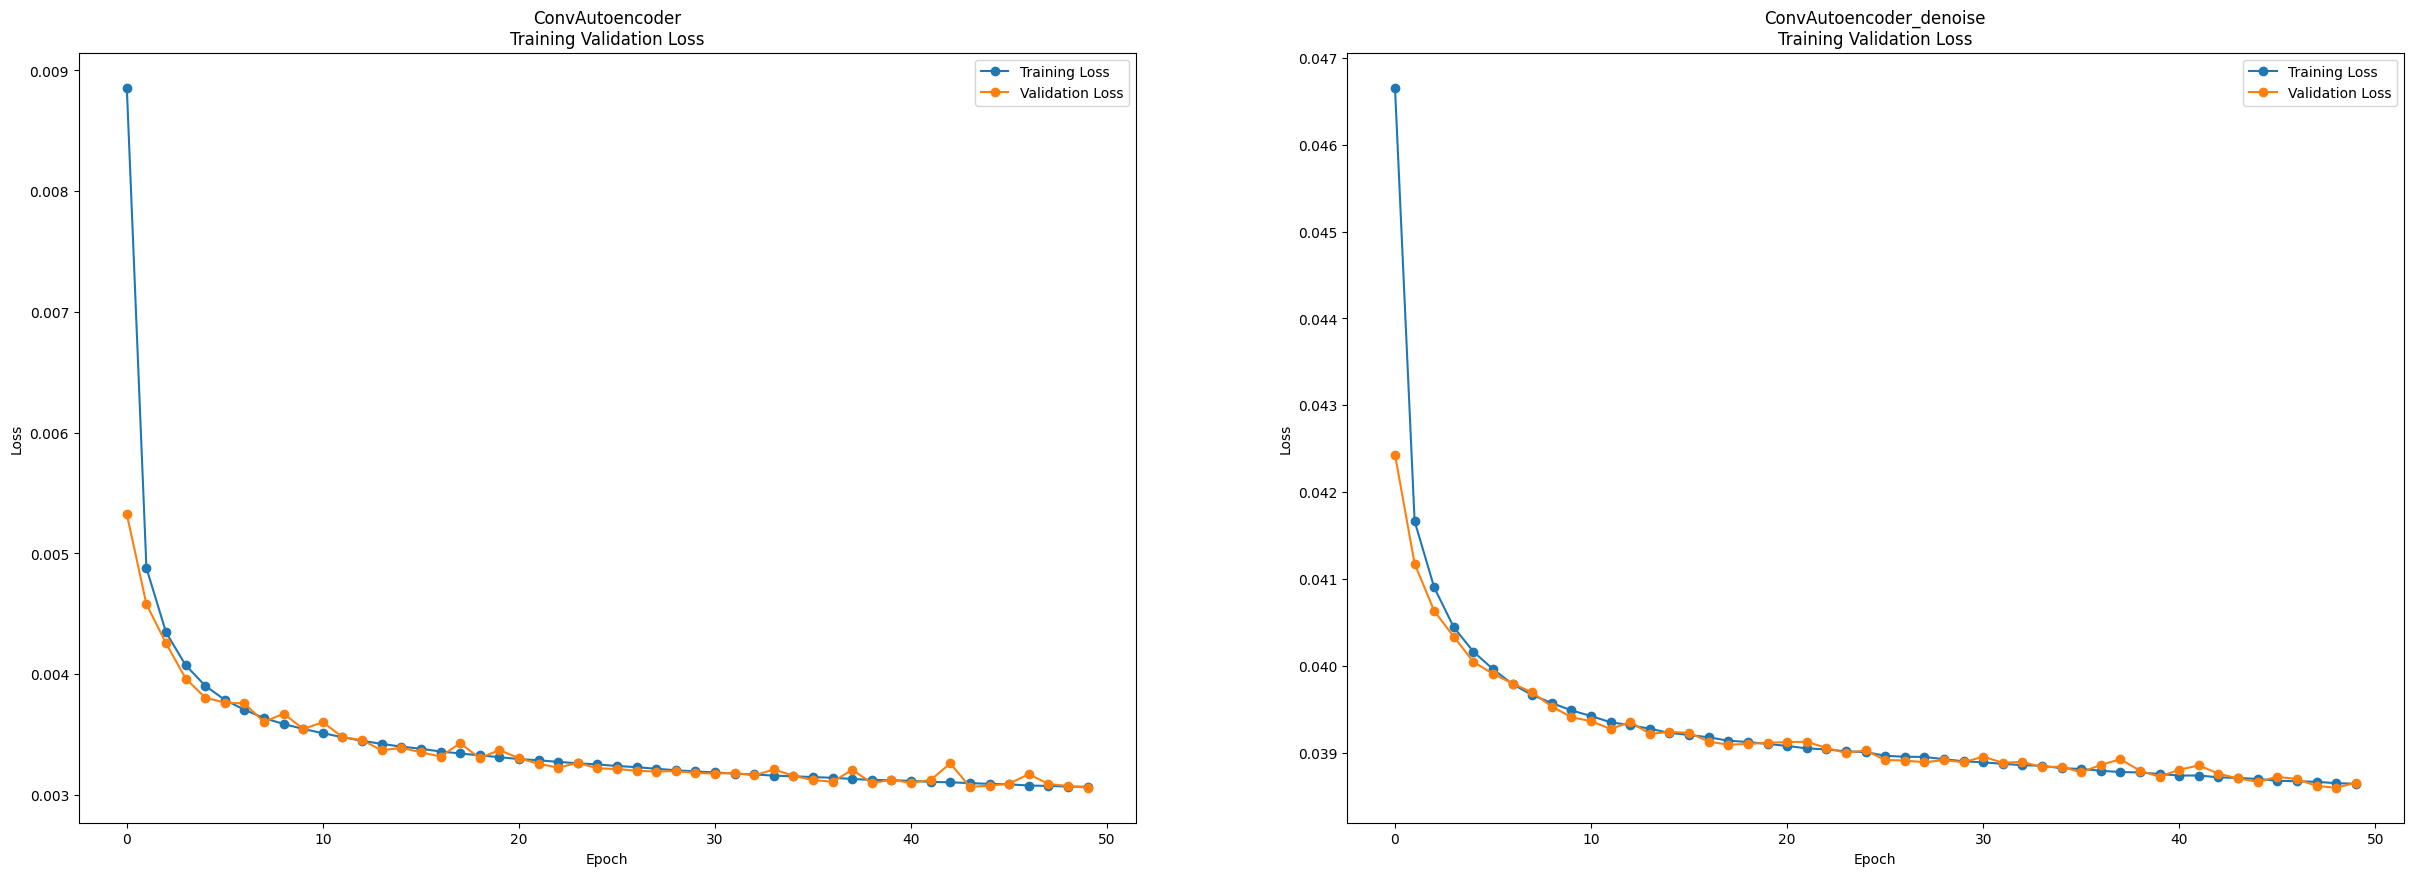

In [14]:
#  Training process

runs = 2
figure, axis = plt.subplots(1, 2, figsize=(30, 10))

for idx in range(runs):
  start = time.time()

  if idx == 0:
    model = ConvAutoencoder()
    model_name = 'ConvAutoencoder'
    train_load = train_dl
    test_load = test_dl
  elif idx == 1:
    model = ConvAutoencoder()
    model_name = 'ConvAutoencoder_denoise'
    train_load = train_dl_noisy
    test_load = test_dl_noisy
  
  print('Training model: ', model_name)
#   print(model)

  model_save_path = os.path.join(os.getcwd(), model_name + '.pt')

  epochs = 50
  lr = 1e-3
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
  # Instantiate summary writer
  writer = SummaryWriter()
  # Instantiate early stopper with patience=3 and tolerance=0
  stopper = EarlyStopper(patience=3, tolerance=0)
  checkpoint_frequency = 3
    
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  train_loss_list = []
  val_loss_list = []
  lowest_loss = np.Inf
    
    

  for epoch in range(epochs):
    train_loss = train(model, train_load, optimizer, criterion, device, idx,lr_scheduler, writer,stopper,checkpoint_frequency)
    train_loss_list.append(train_loss)

    val_loss = validate(model, test_load, optimizer, criterion, device, idx,lr_scheduler, writer,stopper,checkpoint_frequency)
    val_loss_list.append(val_loss)

    if val_loss < lowest_loss:
      torch.save(model.state_dict(), model_save_path)
    

    print('Epoch: {0:3d} | train_loss: {1:2f} | val_loss: {2:2f}'.format(epoch + 1, train_loss, val_loss))

  end = time.time()

  print(f'{model_name} model total training-validation time: {(end-start) / 60} minutes\n')

  plot_metrics(idx, model_name, train_loss_list, val_loss_list)

## Output image comparison

--------------------------------
ConvAutoencoder input images

ConvAutoencoder output/reconstructed images

--------------------------------

--------------------------------
ConvAutoencoder_denoise input images

ConvAutoencoder_denoise output/reconstructed images

--------------------------------



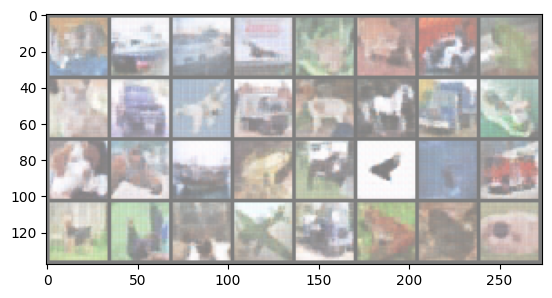

In [21]:
runs = 2

for idx in range(runs):
  if idx == 0:
    model = ConvAutoencoder()
    model.load_state_dict(torch.load('ConvAutoencoder.pt'))
    model_name = 'ConvAutoencoder'
    test_load = DataLoader(test_ds, batch_size=16,
                                         shuffle=False, num_workers=n_cpus,pin_memory=True)
  elif idx == 1:
    model = ConvAutoencoder()
    model.load_state_dict(torch.load('ConvAutoencoder_denoise.pt'))
    model_name = 'ConvAutoencoder_denoise'
    test_load = DataLoader(test_ds_noisy, batch_size=16,
                                         shuffle=False, num_workers=n_cpus,pin_memory=True)

  dataiter = iter(test_dl)
  images, _ = next(dataiter)

  model.eval()
  model.to(device)

  images = images.to(device)

  # Get predictions from model
  y_pred = model(images)

  print('--------------------------------')
  print(model_name, 'input images\n')

  # Print ground truth images
  imshow(torchvision.utils.make_grid(images.cpu()))

  print(model_name, 'output/reconstructed images\n')

  # Print predicted/reconstructed images
  imshow(torchvision.utils.make_grid(y_pred.cpu()))

  print('--------------------------------\n')

Taking a look at the training and validation loss plots, it is evident that both losses are down-trending therefore implying that the autoencoder could still benefit from some additional epochs of training.

## Observations
*	Increasing the number of epochs improved the denoising performance
*	Adding learning scheduler improved the speed of the model.
